## Importing all the necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, power_transform
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

## Reading the dataset using pandas

In [2]:
data = pd.read_csv('loan.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
data.shape

(614, 13)

### We can see that there are 614 rows and 12 columns

### Dropping the Loan_ID feature, because the values are unique for each row and doesn't help in Loan Prediction

In [4]:
data = data.drop(columns = 'Loan_ID')

### Checking for missing values in the dataset

In [5]:
data.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### Upon checking, I can see most of the columns have missing data less than 10%. I'm imputing the same.

In [6]:
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])
data['Married'] = data['Married'].fillna(data['Married'].mode()[0])
data['Dependents'] = data['Dependents'].fillna(data['Dependents'].mode()[0])
data['Self_Employed'] = data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])
data['Credit_History'] = data['Credit_History'].fillna(method = 'bfill')
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0])

In [7]:
data.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

### Loan Amount can be imputed with IterativeImputer with respect to credit history

In [8]:
imp = IterativeImputer()
data[['LoanAmount','Credit_History']] = imp.fit_transform(data[['LoanAmount','Credit_History']])

In [9]:
data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### The missing values have been handled. Lets proceed with the univariate analysis

<AxesSubplot:xlabel='Gender', ylabel='count'>

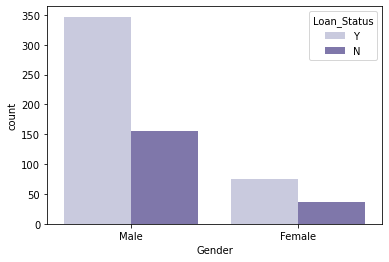

In [10]:
sns.countplot(x = 'Gender',hue = 'Loan_Status', palette = 'Purples', data =data)

### I can see there is a large number of male applicants when compared to female applicants and Male applicants had highest approval rates. We can make use of below figure to visualize the same

<AxesSubplot:xlabel='Gender', ylabel='Approved_Proportion'>

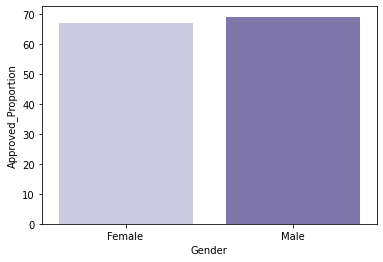

In [11]:
cross = pd.crosstab(index = data['Gender'], columns = data['Loan_Status'])
cr = pd.DataFrame(cross)
cr['Approved_Proportion'] = cr['Y']*100/(cr['Y']+cr['N'])
sns.barplot(x = cr.index, y = cr['Approved_Proportion'], palette = 'Purples')

<AxesSubplot:xlabel='Married', ylabel='count'>

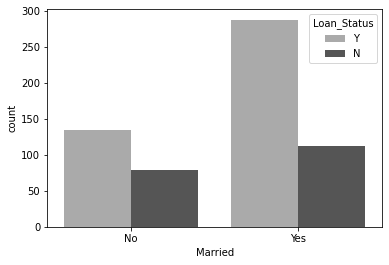

In [12]:
sns.countplot(x = 'Married',hue = 'Loan_Status', palette = 'binary', data =data)

### Using the above and below figures we can say that married people are higest applicants and they had highest approval rates

<AxesSubplot:xlabel='Married', ylabel='Approved_Proportion'>

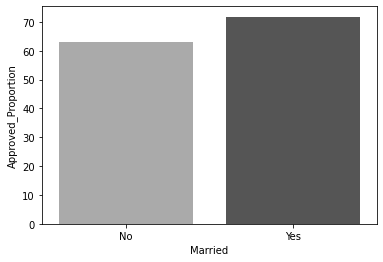

In [13]:
cross = pd.crosstab(index = data['Married'], columns = data['Loan_Status'])
cr = pd.DataFrame(cross)
cr['Approved_Proportion'] = cr['Y']*100/(cr['Y']+cr['N'])
sns.barplot(x = cr.index, y = cr['Approved_Proportion'], palette = 'binary')

<AxesSubplot:xlabel='Dependents', ylabel='count'>

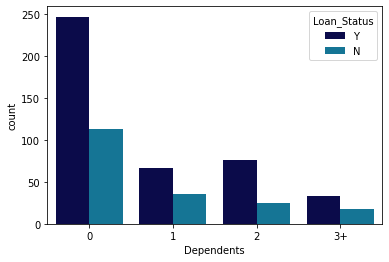

In [14]:
sns.countplot(x = 'Dependents',hue = 'Loan_Status', palette = 'ocean', data =data)

### From the above and below figures we can conclude that the applicants who had no dependents havemode applications, however the the applicants with 2 dependents had highest approval rates

<AxesSubplot:xlabel='Dependents', ylabel='Approved_Proportion'>

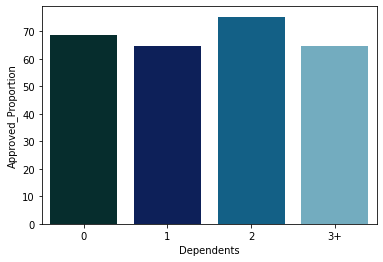

In [15]:
cross = pd.crosstab(index = data['Dependents'], columns = data['Loan_Status'])
cr = pd.DataFrame(cross)
cr['Approved_Proportion'] = cr['Y']*100/(cr['Y']+cr['N'])
sns.barplot(x = cr.index, y = cr['Approved_Proportion'], palette = 'ocean')

<AxesSubplot:xlabel='Education', ylabel='count'>

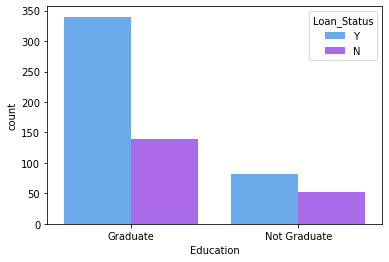

In [16]:
sns.countplot(x = 'Education',hue = 'Loan_Status', palette = 'cool', data =data)

### As per the above and below figure, we can say that graduates have applied for loan more than non-graduates. Further, graduates had higher approval rates

<AxesSubplot:xlabel='Education', ylabel='Approved_Proportion'>

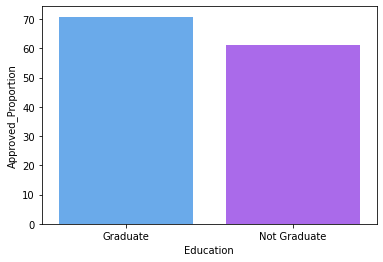

In [17]:
cross = pd.crosstab(index = data['Education'], columns = data['Loan_Status'])
cr = pd.DataFrame(cross)
cr['Approved_Proportion'] = cr['Y']*100/(cr['Y']+cr['N'])
sns.barplot(x = cr.index, y = cr['Approved_Proportion'], palette = 'cool')

<AxesSubplot:xlabel='Self_Employed', ylabel='count'>

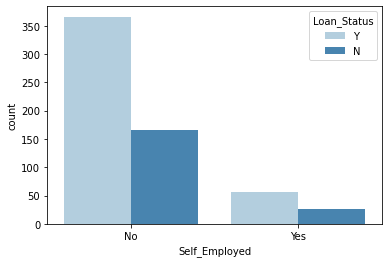

In [18]:
sns.countplot(x = 'Self_Employed',hue = 'Loan_Status', palette = 'Blues', data =data)

### Although the non self employed people applied for loan more than self employed. The approval rates were almost same for both. Therefore, the approval rates are not dependendent whether the applicants are self employed or not

<AxesSubplot:xlabel='Self_Employed', ylabel='Approved_Proportion'>

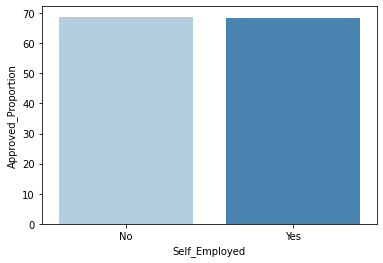

In [19]:
cross = pd.crosstab(index = data['Self_Employed'], columns = data['Loan_Status'])
cr = pd.DataFrame(cross)
cr['Approved_Proportion'] = cr['Y']*100/(cr['Y']+cr['N'])
sns.barplot(x = cr.index, y = cr['Approved_Proportion'], palette = 'Blues')

<AxesSubplot:xlabel='Loan_Amount_Term', ylabel='count'>

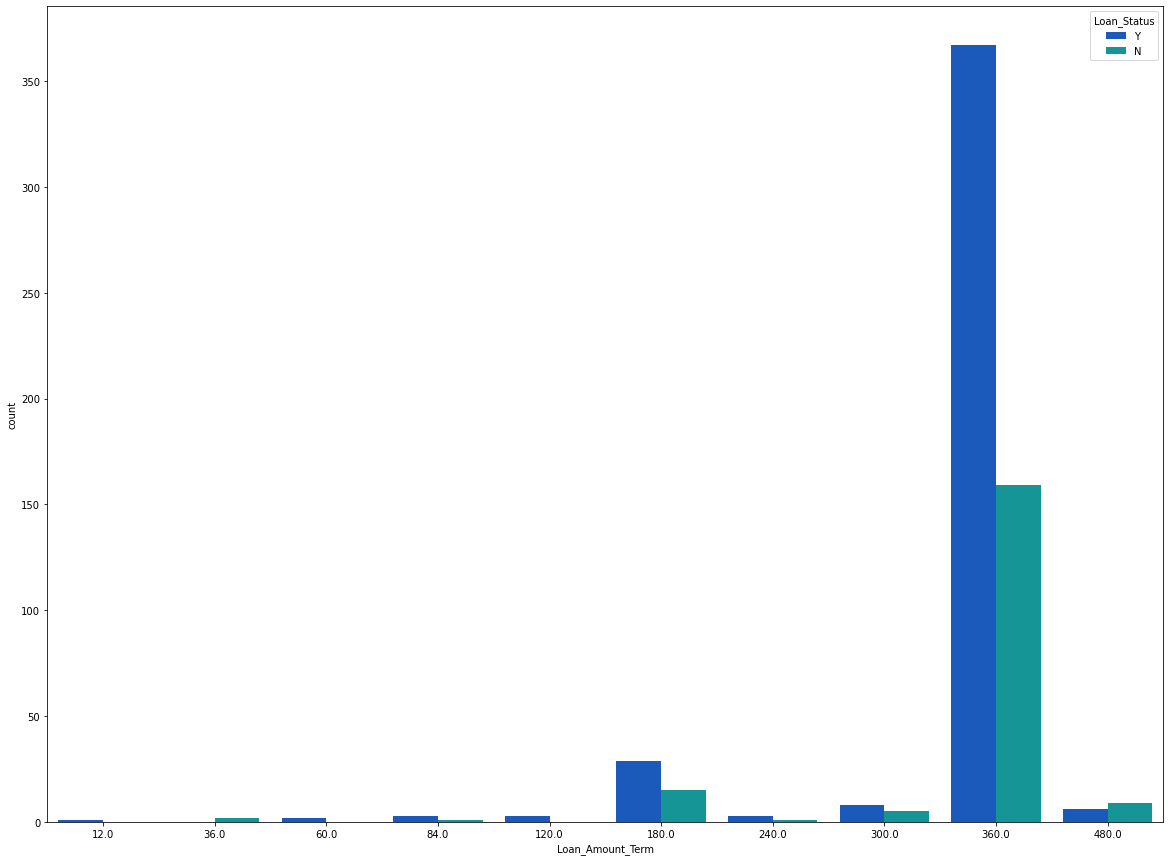

In [20]:
plt.figure(figsize = (20,15))
sns.countplot(x = 'Loan_Amount_Term',hue = 'Loan_Status', palette = 'winter', data =data)

### We can see that the most popular Loan term is 360 months, although the approval rates were 100% for the term of 12, 60 and 120 months

<AxesSubplot:xlabel='Loan_Amount_Term', ylabel='Approved_Proportion'>

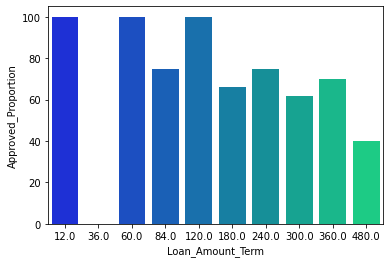

In [21]:
cross = pd.crosstab(index = data['Loan_Amount_Term'], columns = data['Loan_Status'])
cr = pd.DataFrame(cross)
cr['Approved_Proportion'] = cr['Y']*100/(cr['Y']+cr['N'])
sns.barplot(x = cr.index, y = cr['Approved_Proportion'], palette = 'winter')

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

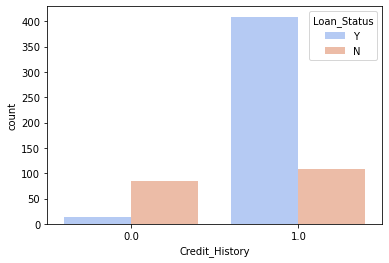

In [22]:
sns.countplot(x = 'Credit_History',hue = 'Loan_Status', palette = 'coolwarm', data =data)

### Upon review, I can see that the most of the applicants had credit history and the applicants with credit history had higher approval rates.

<AxesSubplot:xlabel='Credit_History', ylabel='Approved_Proportion'>

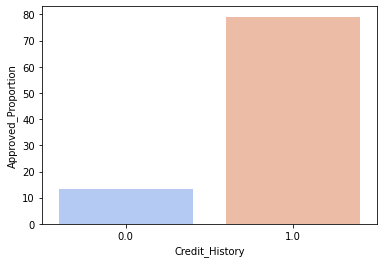

In [23]:
cross = pd.crosstab(index = data['Credit_History'], columns = data['Loan_Status'])
cr = pd.DataFrame(cross)
cr['Approved_Proportion'] = cr['Y']*100/(cr['Y']+cr['N'])
sns.barplot(x = cr.index, y = cr['Approved_Proportion'], palette = 'coolwarm')

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

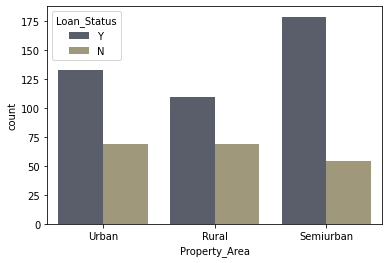

In [24]:
sns.countplot(x = 'Property_Area',hue = 'Loan_Status', palette = 'cividis', data =data)

### From the figures, I can see that the there are more applicants pledging the semi-urban properties and they had higher approval rates. we can also say that the properties which have high potential for price appreciation got more loans approved

<AxesSubplot:xlabel='Property_Area', ylabel='Approved_Proportion'>

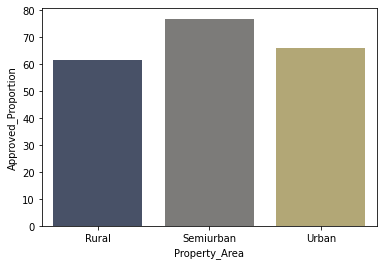

In [25]:
cross = pd.crosstab(index = data['Property_Area'], columns = data['Loan_Status'])
cr = pd.DataFrame(cross)
cr['Approved_Proportion'] = cr['Y']*100/(cr['Y']+cr['N'])
sns.barplot(x = cr.index, y = cr['Approved_Proportion'], palette = 'cividis')

In [26]:
data['ApplicantIncome'] = data['ApplicantIncome'].astype(float)

In [27]:
data.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

<AxesSubplot:xlabel='CoapplicantIncome', ylabel='ApplicantIncome'>

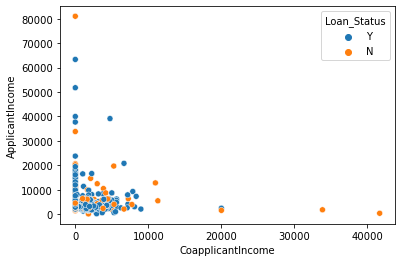

In [28]:
sns.scatterplot(data = data,x ='CoapplicantIncome',y = 'ApplicantIncome', hue='Loan_Status')

### Either Applicant should have higher income or the co applicant should have hgh income for the loan to be approved

### Let's impute the categorical variables before we move ahead

In [29]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849.0,0.0,146.412197,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000.0,0.0,141.000000,360.0,1.0,Urban,Y


### Encoded all the categorical data except Loan Amount term, Althogugh its in number, it is a categorical data

In [30]:
data= pd.get_dummies(data = data,columns =['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area','Loan_Status'], 
                             drop_first = True)

In [31]:
data.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849.0,0.0,146.412197,360.0,1,0,0,0,0,0,0,1,0,1,1
1,4583.0,1508.0,128.000000,360.0,1,1,1,0,0,0,0,1,0,0,0
2,3000.0,0.0,66.000000,360.0,1,1,0,0,0,0,1,1,0,1,1
3,2583.0,2358.0,120.000000,360.0,1,1,0,0,0,1,0,1,0,1,1
4,6000.0,0.0,141.000000,360.0,1,0,0,0,0,0,0,1,0,1,1


### Using the Binary Encoder to encode the Loan_Amount_Term

In [32]:
be = BinaryEncoder()
enc_data = be.fit_transform(data['Loan_Amount_Term'].astype(str), return_df = True)
enc_data.head()

,Loan_Amount_Term_0,Loan_Amount_Term_1,Loan_Amount_Term_2,Loan_Amount_Term_3,Loan_Amount_Term_4
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


### Joining the encoded data and deleting the existing column (uncoded)

In [33]:
dataset = pd.concat([data,enc_data], axis = 1)
dataset = dataset.drop(columns = 'Loan_Amount_Term')
dataset.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,Loan_Amount_Term_0,Loan_Amount_Term_1,Loan_Amount_Term_2,Loan_Amount_Term_3,Loan_Amount_Term_4
0,5849.0,0.0,146.412197,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1
1,4583.0,1508.0,128.000000,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,3000.0,0.0,66.000000,1,1,0,0,0,0,1,1,0,1,1,0,0,0,0,1
3,2583.0,2358.0,120.000000,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1
4,6000.0,0.0,141.000000,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1


## Let's find the correlation for the independent variables with dependent variable

In [34]:
corr_data = dataset.corr()
corr_data['Loan_Status_Y'].sort_values(ascending = False)

Loan_Status_Y              1.000000
Credit_History_1.0         0.516944
Property_Area_Semiurban    0.136540
Married_Yes                0.091478
Dependents_2               0.062384
Loan_Amount_Term_4         0.026625
Gender_Male                0.017987
Self_Employed_Yes         -0.003700
ApplicantIncome           -0.004710
Dependents_3+             -0.026123
Loan_Amount_Term_1        -0.026840
LoanAmount                -0.036416
Dependents_1              -0.038740
Property_Area_Urban       -0.043621
Loan_Amount_Term_3        -0.055966
CoapplicantIncome         -0.059187
Loan_Amount_Term_2        -0.063233
Education_Not Graduate    -0.085884
Loan_Amount_Term_0              NaN
Name: Loan_Status_Y, dtype: float64

### I can see that there is a highest correlation for the column credit history with the target and Loan_Amount_Term_0 has no correlation because it contains 0 for all rows due to binary encoding

### Removing the column Loan_Amount_Term_0

In [35]:
dataset  = dataset.drop(columns ='Loan_Amount_Term_0')

## Lets plot the heatmap to visualize the correlation and multi-collenearity

<AxesSubplot:>

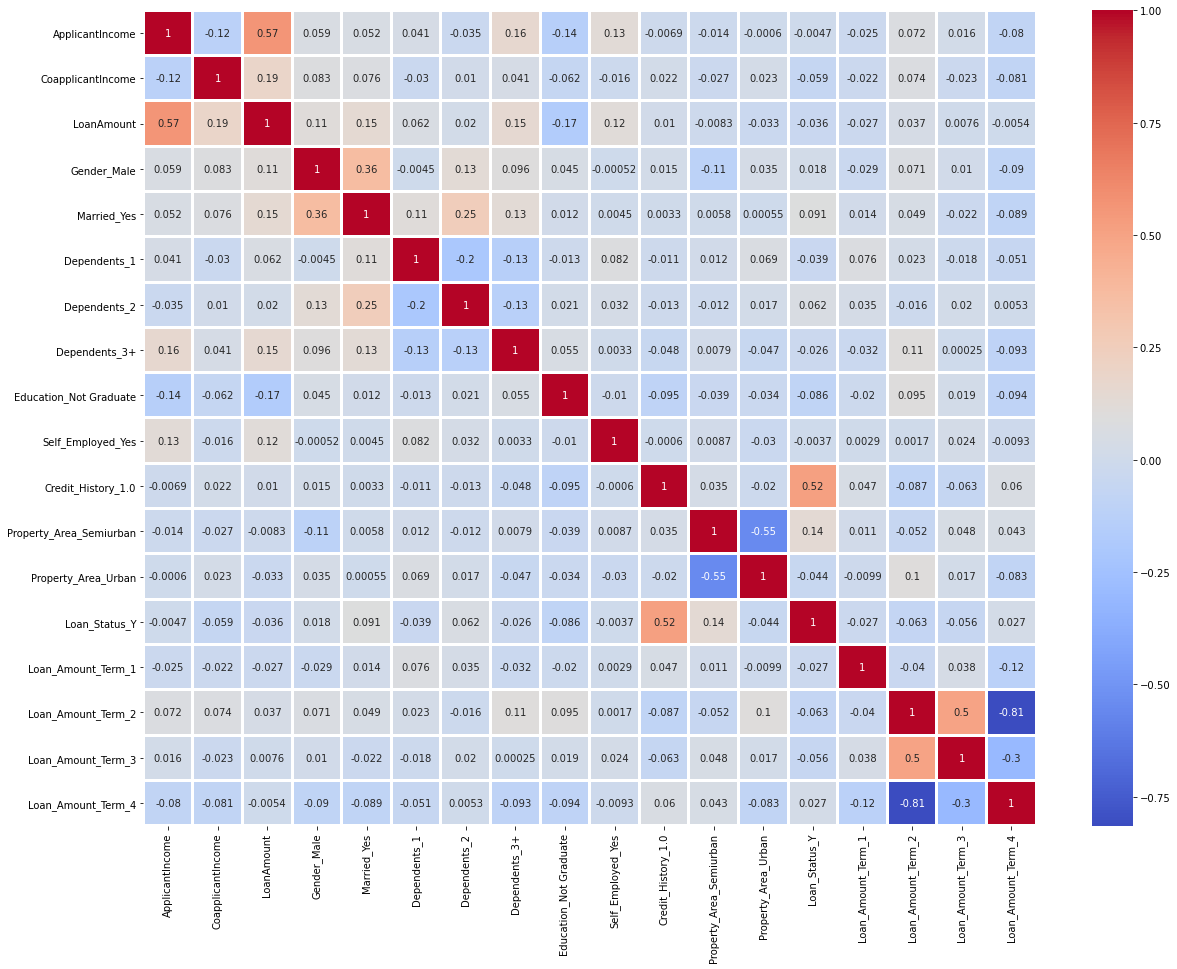

In [36]:
cor = dataset.corr()
plt.figure(figsize = (20,15))
sns.heatmap(cor, annot = True, linewidths=2, cmap = 'coolwarm')

### I can see that the columns Loan_Amount_term_2 and Loan_Amount_Term_4 is highly correlated. However I'm proceeding with the model building

### Checking for outliers. Since there are only 3 columns with continuous data type using the same to detect outliers

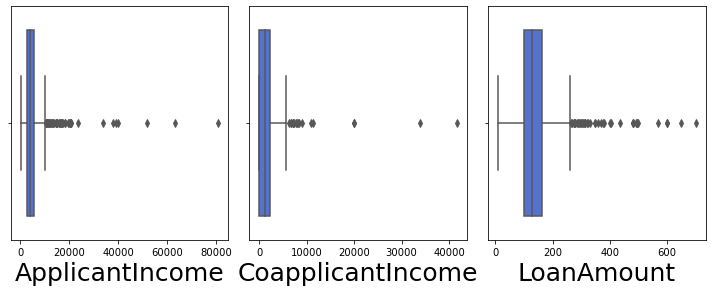

In [37]:
plt.figure(figsize= (10,120))
pltnum = 1
for i in dataset.iloc[:,:3]:
    if pltnum <=30:
        plt.subplot(30,3,pltnum)
        sns.boxplot(dataset[i],color = 'royalblue', orient = 'v')
        plt.xlabel(i,fontsize=25)
    pltnum+=1
plt.tight_layout()

### Removing outlier with the zscore method first

In [38]:
z = np.abs(zscore(dataset[['ApplicantIncome','CoapplicantIncome','LoanAmount']]))

In [39]:
ds_new = dataset[(z<1.8).all(axis = 1)]
print(ds_new.shape)
print(dataset.shape)

(564, 18)
(614, 18)


In [40]:
print('The data loss Percentage for removing outlier using the IQR is ', 100-((564/614)*100))

The data loss Percentage for removing outlier using the IQR is  8.14332247557003


## I can see that there is a 6% data loss with the zscore method, Let's try with IQR method

In [41]:
q1 = dataset[['ApplicantIncome','CoapplicantIncome','LoanAmount']].quantile(0.25)
q3 = dataset[['ApplicantIncome','CoapplicantIncome','LoanAmount']].quantile(0.75)
iqr = q3-q1

In [42]:
dnew = dataset[~((dataset < (q1 - 1.5*iqr))|(dataset>(q3+1.5*iqr))).any(axis = 1)]
print(dataset.shape)
print(dnew.shape)

(614, 18)
(535, 18)


In [43]:
print('The data loss Percentage for removing outlier using the IQR is ', 100 - (535/614)*100)

The data loss Percentage for removing outlier using the IQR is  12.866449511400646


### Here the data loss of IQR is higher than the zscore method, hence using the zscore method for removing the outlier

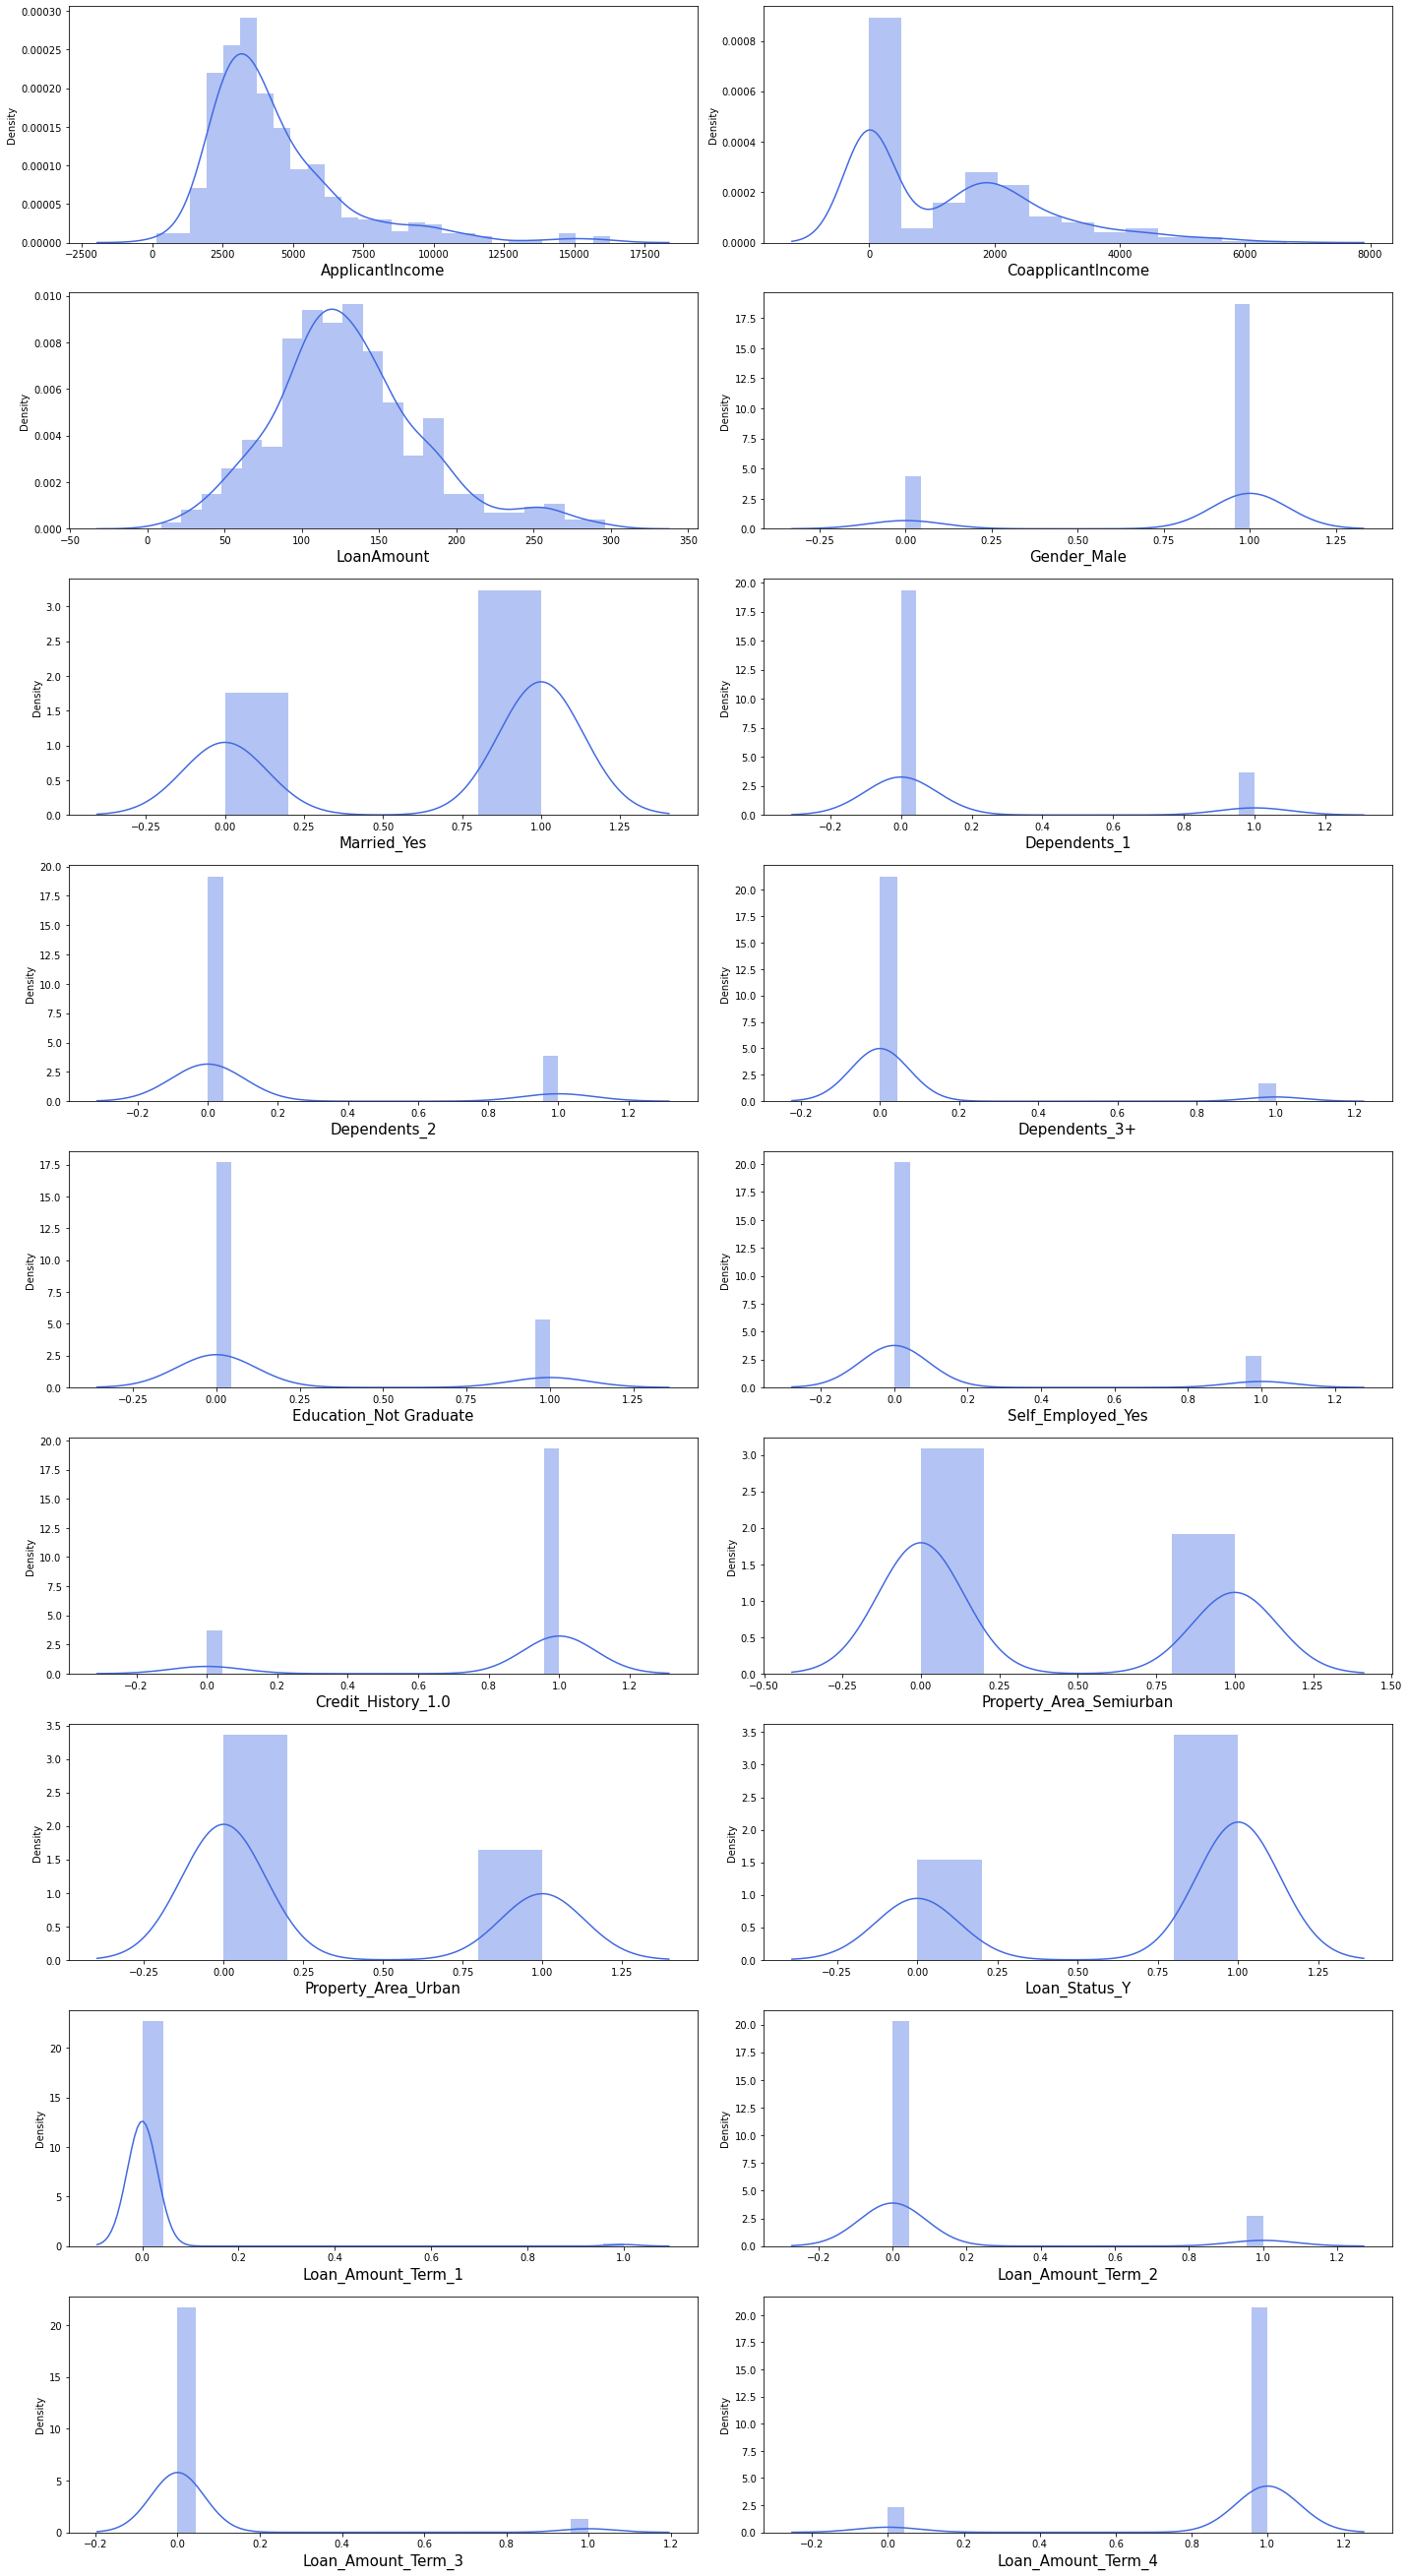

In [44]:
plt.figure(figsize= (20,40))
pltnum = 1
for i in ds_new:
    if pltnum <=20:
        plt.subplot(10,2,pltnum)
        sns.distplot(ds_new[i],color = 'royalblue')
        plt.xlabel(i,fontsize=15)
    pltnum+=1
plt.tight_layout()

### I can see there is skewness in the continuous column data. Let's check whether the skewness in under control

In [45]:
ds_new.skew()

ApplicantIncome            1.892582
CoapplicantIncome          0.947140
LoanAmount                 0.631342
Gender_Male               -1.601823
Married_Yes               -0.617579
Dependents_1               1.882361
Dependents_2               1.793628
Dependents_3+              3.250415
Education_Not Graduate     1.271408
Self_Employed_Yes          2.286182
Credit_History_1.0        -1.846161
Property_Area_Semiurban    0.482742
Property_Area_Urban        0.734605
Loan_Status_Y             -0.831389
Loan_Amount_Term_1         8.831684
Loan_Amount_Term_2         2.389211
Loan_Amount_Term_3         3.842347
Loan_Amount_Term_4        -2.687014
dtype: float64

### All the continuous data column is skewed. Therefore splitting the data and applying the transformation technique on the independent variable

In [46]:
x = ds_new.drop(columns = 'Loan_Status_Y')
y = ds_new['Loan_Status_Y']

### Applygint the power transformation technique using the yeo-johnson

In [47]:
trs = power_transform(x, method = 'yeo-johnson')
x = pd.DataFrame(trs, columns = x.columns)

In [48]:
x.skew()

ApplicantIncome            0.054736
CoapplicantIncome         -0.168478
LoanAmount                 0.044966
Gender_Male               -1.601823
Married_Yes               -0.617579
Dependents_1               1.882361
Dependents_2               1.793628
Dependents_3+              3.250415
Education_Not Graduate     1.271408
Self_Employed_Yes          2.286182
Credit_History_1.0        -1.846161
Property_Area_Semiurban    0.482742
Property_Area_Urban        0.734605
Loan_Amount_Term_1         8.831684
Loan_Amount_Term_2         2.389211
Loan_Amount_Term_3         3.842347
Loan_Amount_Term_4        -2.687014
dtype: float64

### As we can see the skewness of the data is under control now. let's visualize the boxplot for outlier

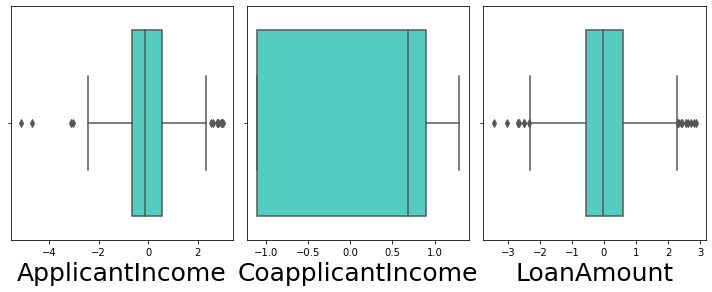

In [49]:
plt.figure(figsize= (10,120))
pltnum = 1
for i in x.iloc[:,:3]:
    if pltnum <=30:
        plt.subplot(30,3,pltnum)
        sns.boxplot(x[i],color = 'turquoise', orient = 'v')
        plt.xlabel(i,fontsize=25)
    pltnum+=1
plt.tight_layout()

### the ouliers are reduced to an considerably after removing outliers and applying transformation techniques

### Let's visualize the distribution

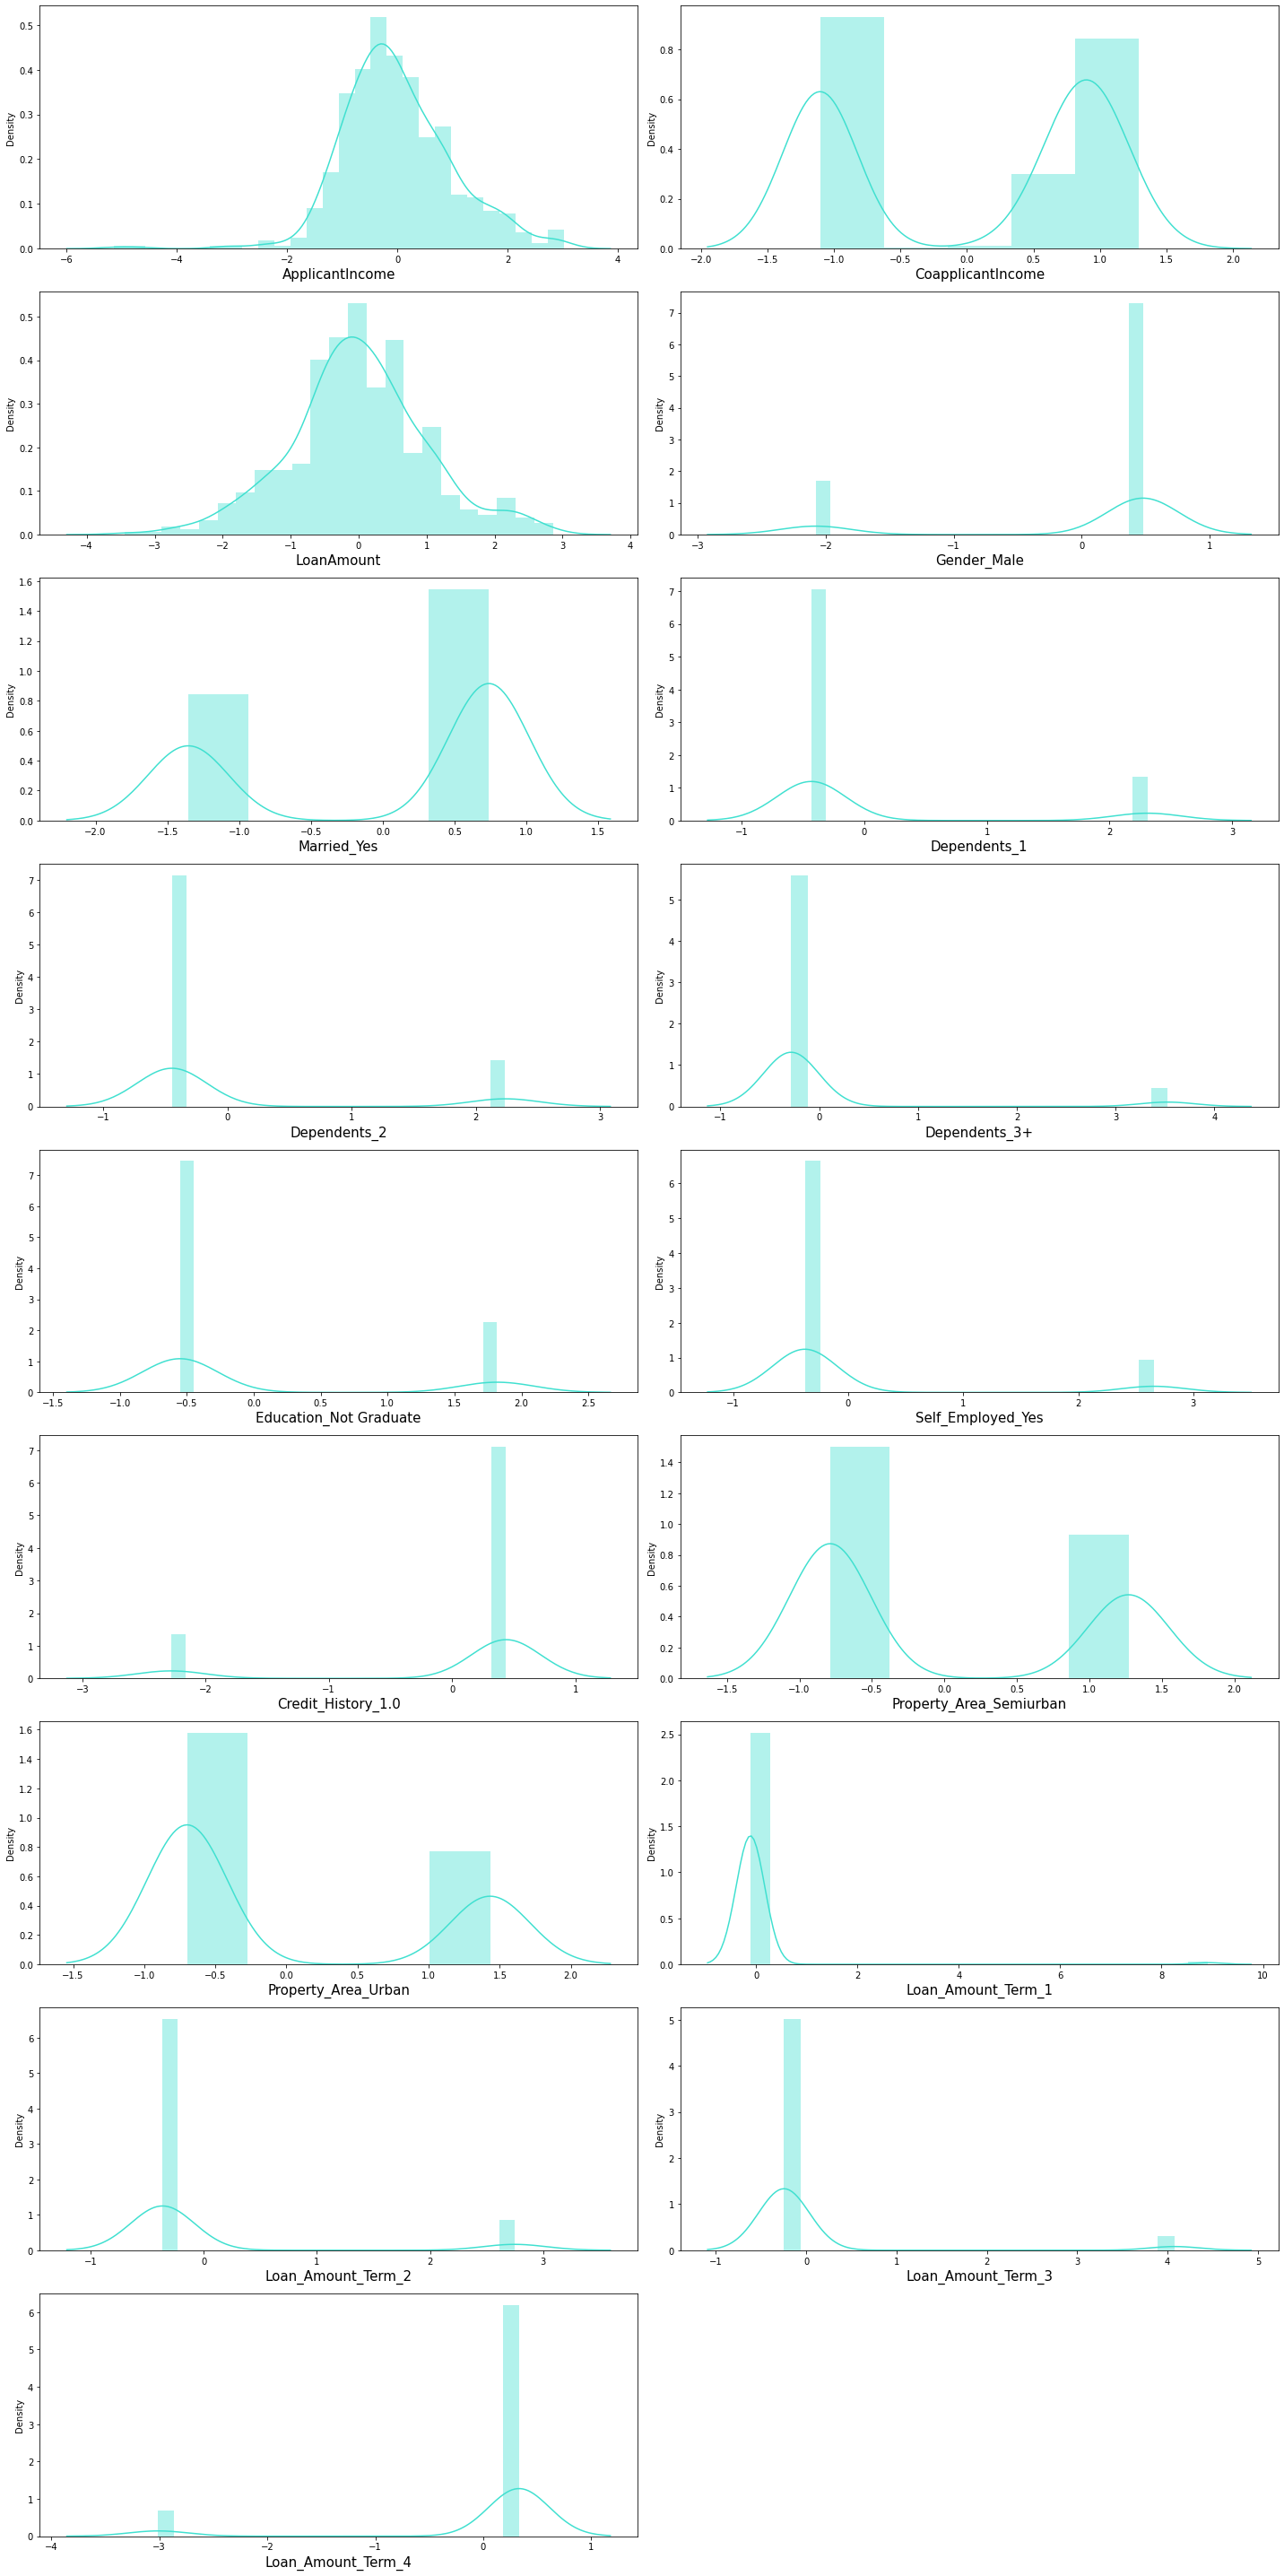

In [50]:
plt.figure(figsize= (20,40))
pltnum = 1
for i in x:
    if pltnum <=18:
        plt.subplot(9,2,pltnum)
        sns.distplot(x[i],color = 'turquoise')
        plt.xlabel(i,fontsize=15)
    pltnum+=1
plt.tight_layout()

### Now the continuous columns in the dataset is looking normal without skewness

In [51]:
y.value_counts()

1    390
0    174
Name: Loan_Status_Y, dtype: int64

### We saw in the univariate analysis, there is a fair amount of variatoin with the class 1 (Loan Approved/Y/Yes). Also there is more than 1:2 ratio of class imbalance. Hence I'm applying the oversampling technique to treat the class imabalance issue

In [52]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_over,y_over = sm.fit_resample(x,y)

In [53]:
y_over.value_counts()

0    390
1    390
Name: Loan_Status_Y, dtype: int64

### Now the class is balanced, I'm proceeding with fitting the model.

## Finding the best random state

In [54]:
from sklearn.linear_model import LogisticRegression
rs = 0
for i in range(0,3000):
    x_train,x_test, y_train,y_test = train_test_split(x_over,y_over,test_size = 0.3, random_state = i)
    lg = LogisticRegression()
    lg.fit(x_train,y_train)
    ts_pred = lg.predict(x_test)
    tr_pred = lg.predict(x_train)
    ts_score = accuracy_score(y_test,ts_pred)
    tr_score = accuracy_score(y_train, tr_pred)
    if round(ts_score*100,1) == round(tr_score*100,1):
        if i>rs:
            rs = i
print('the best random state for the data set is', rs)

the best random state for the data set is 2748


### Splitting the data into train and test

In [55]:
x_train,x_test,y_train,y_test = train_test_split(x_over,y_over, test_size =0.3, random_state = rs)

## Model 1: Logistic Rregression

In [56]:
lg = LogisticRegression()
lg.fit(x_train,y_train)
lg_pred = lg.predict(x_test)
lg_score = accuracy_score(y_test,lg_pred)
print('The Accuracy score for the Logistic Regression is' , lg_score)

The Accuracy score for the Logistic Regression is 0.7435897435897436


## Model 2: Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
rf_pred =rf.predict(x_test)
rf_score = accuracy_score(y_test,rf_pred)
print('The Accuracy score for the Random Forest Classifier is' , rf_score)

The Accuracy score for the Random Forest Classifier is 0.8247863247863247


## Model 3: KNeighbors Classifier

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)
knn_score = accuracy_score(y_test,knn_pred)
print('The Accuracy score for the KNeigbhors Classifier is' , knn_score)

The Accuracy score for the KNeigbhors Classifier is 0.7307692307692307


## Model 4: Extra Trees Classifier

In [59]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier()
et.fit(x_train,y_train)
et_pred = et.predict(x_test)
et_score = accuracy_score(y_test,et_pred)
print('The Accuracy score for the Extra Trees Classifier is' , et_score)

The Accuracy score for the Extra Trees Classifier is 0.8162393162393162


## Model 5: XGB Classifier

In [60]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eval_metric = 'logloss',use_label_encoder=False)
xgb.fit(x_train,y_train)
xgb_pred = xgb.predict(x_test)
xgb_score = accuracy_score(y_test,xgb_pred)
print('The Accuracy score for the XG Boost Classifier is' , xgb_score)

The Accuracy score for the XG Boost Classifier is 0.7905982905982906


### Lets validate the scores we got using the cross validation

In [61]:
cv = cross_val_score(lg,x_over,y_over, cv = 7)
cv1 = cv.mean()
cv1

0.7205598455598456

In [62]:
cv1 = cross_val_score(rf,x_over,y_over, cv = 7)
cv2 = cv1.mean()
cv2

0.8348501562787277

In [63]:
cv2 = cross_val_score(knn,x_over,y_over, cv = 7)
cv3 = cv2.mean()
cv3

0.7436109578966723

In [64]:
cv3 = cross_val_score(et,x_over,y_over, cv = 7)
cv4 = cv3.mean()
cv4

0.8335286817429675

In [65]:
cv4 = cross_val_score(xgb,x_over,y_over, cv = 7)
cv5 = cv4.mean()
cv5

0.8053640375068946

### Finding the best model

In [66]:
model = [lg_score,rf_score,knn_score,et_score,xgb_score]
cross = [0.7205483544769259,0.8400785990071704,0.7306719985291413,0.8425376907519765,0.8169240669240668]
model_selection = pd.DataFrame({})
model_selection['Model'] = model
model_selection['Cross']  = cross
model_selection['difference'] = model_selection['Model'] - model_selection['Cross'] 
model_selection

,Model,Cross,difference
0,0.743590,0.720548,0.023041
1,0.824786,0.840079,-0.015292
2,0.730769,0.730672,0.000097
3,0.816239,0.842538,-0.026298
4,0.790598,0.816924,-0.026326


### As per the above data, the best model is Random Forest Classifier. Proceeding with hyper parameter tuning

## Hyper Parameter Tuning

In [67]:
params ={'n_estimators':[100,150,200,250],
        'criterion':['gini','entropy'],
        'max_depth':[13,15,16,17],
        'min_samples_split':[2,3,4,5,6],
        'bootstrap':[True,False],
        'n_jobs':[-1,-2,-3]}

In [68]:
gcv = GridSearchCV(RandomForestClassifier(), params, cv = 5, n_jobs =-1)
gcv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [13, 15, 16, 17],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [100, 150, 200, 250],
                         'n_jobs': [-1, -2, -3]})

In [69]:
gcv.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 13,
 'min_samples_split': 2,
 'n_estimators': 100,
 'n_jobs': -2}

### Fitting the best params to the model

In [70]:
fnl_mod = RandomForestClassifier(bootstrap = False, criterion = 'gini', max_depth = 17, min_samples_split = 2,
                                n_estimators = 250, n_jobs = -3)
fnl_mod.fit(x_train,y_train)
fnl_pred  = fnl_mod.predict(x_test)
fnl_score  = accuracy_score(y_test,fnl_pred)
print('The Accuracy score for the Tuned Decision Trees Classifier is' , fnl_score)

The Accuracy score for the Tuned Decision Trees Classifier is 0.8162393162393162


### Classification report

In [71]:
print(classification_report(y_test,fnl_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       117
           1       0.80      0.84      0.82       117

    accuracy                           0.82       234
   macro avg       0.82      0.82      0.82       234
weighted avg       0.82      0.82      0.82       234



### the classification report for non hyper parameter tuned model

In [72]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       117
           1       0.82      0.83      0.83       117

    accuracy                           0.82       234
   macro avg       0.82      0.82      0.82       234
weighted avg       0.82      0.82      0.82       234



## ROC AUC scores for hyper parameter tuned model and basic model

In [73]:
print(roc_auc_score(y_test, fnl_pred))

0.8162393162393164


In [74]:
print(roc_auc_score(y_test, rf_pred))

0.8247863247863247


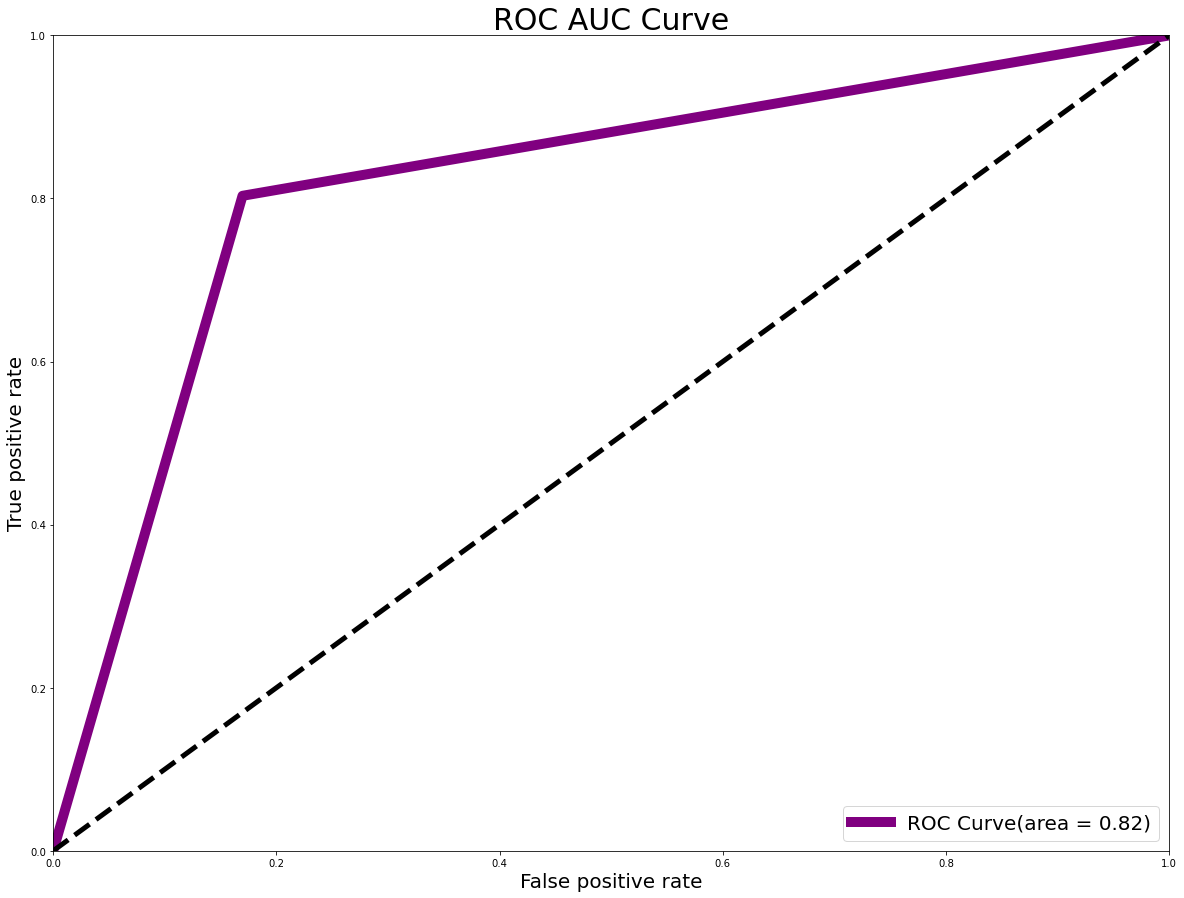

In [75]:
from sklearn.metrics import roc_curve, auc
fpr,tpr, thresholds  = roc_curve(fnl_pred, y_test)
roc_auc = auc(fpr,tpr)

plt.figure(figsize = (20,15))
plt.plot(fpr, tpr, lw=10, color = 'purple',label = 'ROC Curve(area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],lw =5, color ='black', linestyle = '--')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.xlabel('False positive rate', fontsize = 20)
plt.ylabel('True positive rate', fontsize  =20)
plt.title('ROC AUC Curve', fontsize = 30)
plt.legend(loc ='lower right', fontsize = 20)
plt.show()

## Saving the model

In [76]:
import joblib
joblib.dump(fnl_mod,'Loan_prediction.pkl')

['Loan_prediction.pkl']